In [103]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('large_repr', 'truncate')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

In [104]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
sns.set_palette(colours)
%matplotlib inline

In [105]:
import sys
sys.path.insert(0, '../src')
from ds_toolbox import create_balanced_dataset, plot_confusion_matrix_with_labels, compute_metrics

In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
DATA_PATH = Path("../data/")
DOCUMENTATION_PATH = Path("../documentation")
RANDOM_STATE_PARAMETER = 42
TEST_SIZE = .25

In [34]:
data = pd.read_csv(DATA_PATH / "apld_patients.csv")
data.reset_index(inplace=True)
data.drop(["BC_PATIENT", "SN_PATIENT", "DIAGNOSIS_CODE", "index"], axis=1, inplace=True)
data.rename(columns={"SERVICE_DATE_y": "Service_date", "SEASON": "Season"}, inplace=True)
cols = ['PATIENT_ID',
 'Service_date',
 'Season',
 'PRC_STD_CD',
 'Blood',
 'Bone',
 'Breast',
 'Heart',
 'Lungs',
 'Medication',
 'Medication ',
 'Other',
 'Skin',
 'Stomach',
 'Vagina',
  'mBC_PATIENT']
data = data[cols]
data.head()

,PATIENT_ID,Service_date,Season,PRC_STD_CD,Blood,Bone,Breast,Heart,Lungs,Medication,Medication,Other,Skin,Stomach,Vagina,mBC_PATIENT
0,134290358,10/15/2015,4,99214,0,0,0,0,0,0,0,1,0,0,0,True
1,134290358,10/15/2015,4,99214,0,0,0,0,0,0,0,1,0,0,0,True
2,134290358,10/15/2015,4,99214,0,0,0,0,0,0,0,1,0,0,0,True
3,1057559593,11/25/2015,4,85025,0,0,0,0,0,0,0,1,0,0,0,True
4,1057559593,11/25/2015,4,36415,0,0,0,0,0,0,0,1,0,0,0,True


In [35]:
data.columns

Index(['PATIENT_ID', 'Service_date', 'Season', 'PRC_STD_CD', 'Blood', 'Bone',
       'Breast', 'Heart', 'Lungs', 'Medication', 'Medication ', 'Other',
       'Skin', 'Stomach', 'Vagina', 'mBC_PATIENT'],
      dtype='object')

In [36]:
FEATURES = ['Season', 'Medication', 'Blood', 'Bone',
       'Breast', 'Heart', 'Lungs', 'Medication', 
       'Skin', 'Stomach', 'Vagina', 'Other', 'mBC_PATIENT']
model_data = data[FEATURES]

In [37]:
x_train, x_test, y_train, y_test = train_test_split(
        model_data.iloc[:,:-1],
         model_data.iloc[:,-1].values.ravel(),
        random_state = RANDOM_STATE_PARAMETER,
        test_size=TEST_SIZE,
    )            

# Random forest classifier 

In [127]:
rf = RandomForestClassifier()      
rf = rf.fit(x_train,y_train)
y_prediction = rf.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.6087009475555989, sensitivity:0.8248325181866755, specificity:0.2942231790455687


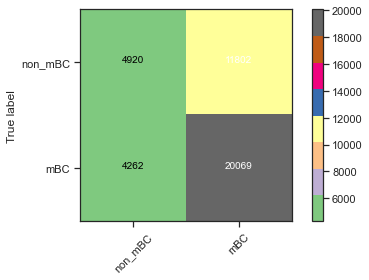

In [129]:
plot_confusion_matrix_with_labels(x_test, y_test, rf, ["non_mBC", "mBC"], filename="random_forest.pdf")

# Logistic Regression

In [123]:
%%time
model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':[1e-4,1e-3,1e-2,0.1,1],
    'penalty':['l1','l2']
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 5, n_jobs=4,
                              random_state = 20)
lr_search.fit(x_train, y_train)
print('Best parameters:', lr_search.best_params_)
best_lr_model = lr_search.best_estimator_
y_prediction = best_lr_model.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

Best parameters: {'penalty': 'l2', 'C': 0.1}
accuracy:0.502545489976372, sensitivity:0.507377419752579, specificity:0.49551489056332976
CPU times: user 1.02 s, sys: 158 ms, total: 1.18 s
Wall time: 1.48 s


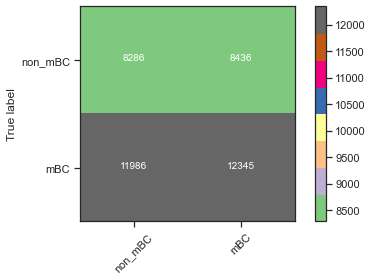

In [124]:
plot_confusion_matrix_with_labels(x_test, y_test, best_lr_model, ["non_mBC", "mBC"], filename="logistic_reg.pdf")

# Logistic Regression on oversampled data

In [110]:
X_sampled, y_sampled = create_balanced_dataset('ADASYN', x_train.values, y_train)

X=(123157, 12), y=[(False, 50129), (True, 73028)]
X_sampled=(139579, 12), y_sampled=[(False, 66551), (True, 73028)]


In [122]:
%%time
model = LogisticRegression()
#model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':[1e-4,1e-3,1e-2,0.1,1],
    'penalty':['l1','l2']
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 5, n_jobs=4,
                              random_state = 20)
lr_search.fit(X_sampled, y_sampled)
print('Best parameters:', lr_search.best_params_)
oversampling_best_lr_model = lr_search.best_estimator_
y_prediction = oversampling_best_lr_model.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

Best parameters: {'penalty': 'l2', 'C': 0.0001}
accuracy:0.502448054953353, sensitivity:0.705232008548765, specificity:0.20739146035163258
CPU times: user 553 ms, sys: 83.4 ms, total: 636 ms
Wall time: 1.37 s


# Random Forest on oversampled data

In [130]:
oversampling_rf = RandomForestClassifier()      
oversampling_rf = oversampling_rf.fit(X_sampled,y_sampled)
y_prediction = oversampling_rf.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.5184517574842277, sensitivity:0.5300645267354404, specificity:0.5015548379380457
